In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import random

from experiments.npe.model import get_npe_model

In [2]:
with open('data/threecircles_munk_full.p', 'rb') as f:
    data = pickle.load(f)

In [3]:
train_x, train_y, _ = data['train']
val_x, val_y = data['val']

train_x = np.array(train_x)
train_y = np.array(train_y)

val_x = np.array(val_x)
val_y = np.array(val_y)

In [4]:
len(train_x[0])

5

In [5]:
def breakdown(X):
    return [np.array([x[i] for x in X]) for i in range(len(X[0]))]

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

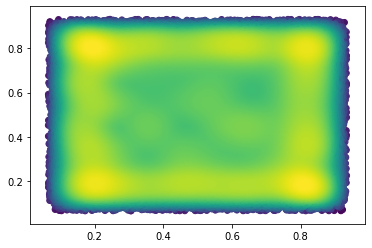

In [159]:
px = []
py = []

for t in range(len(train_x)):
    points_p = np.array([train_x[t][i][:2] for i in range(3)])
    points_n = np.array([train_x[t][i][2:] for i in range(3)])

#     plt.scatter(points_p[:, 0], points_p[:, 1])
#     plt.scatter(points_n[:, 0], points_n[:, 1])
#     plt.scatter([train_x[t][0][2:][0] + train_y[t][0]], [train_x[t][0][2:][1] + train_y[t][1]])

    # Position
    px.append(train_x[t][0][:2][0])
    py.append(train_x[t][0][:2][1])
    
    # Velocity
#     px.append(points_n[0][0] - points_p[0][0])
#     py.append(points_n[0][1] - points_p[0][1])
    
#     px.append(points_p[0][0])
#     py.append(points_p[0][1])
    
density_scatter(np.array(px), np.array(py), bins=10)

In [5]:
train_x[0]

array([array([ 0.6734375 ,  0.85546875, -0.20135081,  0.75369077,  0.66306668,
        0.91784411, -0.34994342, -0.7536976 ]),
       array([0.74882812, 0.70390625, 0.42287457, 0.59242487, 0.78012912,
       0.72550466, 0.57146718, 0.34827979]),
       array([ 0.51328125,  0.75273437, -0.18819043, -0.21944898,  0.4943042 ,
        0.73477623, -0.18819043, -0.21944898]),
       array([1.]), array([1.])], dtype=object)

In [161]:
train_x[1]

[array([ 0.24655922,  0.65929063,  0.59151454, -0.36129017,  0.28121827,
         0.63812128,  0.59151454, -0.36129017]),
 array([ 0.686394  ,  0.64127372, -0.39367649,  0.30549724,  0.66332702,
         0.65917395, -0.39367649,  0.30549724]),
 array([ 0.52612033,  0.19798424, -1.67200841,  0.38269916,  0.42815109,
         0.22040802, -1.67200841,  0.38269916]),
 array([1.]),
 array([1.])]

In [12]:
# with tf.device('/cpu:0'):
model = get_npe_model(max_pairs = 2, state_dim = 4, hidden_size = 200, variational = True)

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
# model.compile(loss='mse', optimizer=opt)
model.compile(loss=lambda y, d: -d.log_prob(y), optimizer=opt, metrics=['mse'])

In [18]:
model.evaluate(breakdown(val_x[:10000]), val_y[:10000], verbose=0)

0.046732464984059335

In [163]:
b_train_x = breakdown(train_x)
b_val_x = breakdown(val_x)

In [17]:
history = model.fit(breakdown(train_x), np.array(train_y), validation_data=(breakdown(val_x), np.array(val_y)), epochs=100, batch_size=1024)

Train on 3000000 samples, validate on 300000 samples
Epoch 1/100
3000000/3000000 [==============================] - 40s 13us/sample - loss: 2517.2224 - mse: 0.0922 - val_loss: 6.9659 - val_mse: 0.0740
Epoch 2/100
3000000/3000000 [==============================] - 39s 13us/sample - loss: -0.9318 - mse: 0.1051 - val_loss: -5.8841 - val_mse: 0.0798
Epoch 3/100
 211968/3000000 [=>............................] - ETA: 35s - loss: -4.9886 - mse: 0.0975

KeyboardInterrupt: 

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

NameError: name 'history' is not defined

In [38]:
p = model.predict(breakdown(val_x))

In [60]:
(((np.vstack(val_x[:, 0])[:, 6:] + p) - (np.vstack(val_x[:, 0])[:, 6:] + val_y))**2).mean()

0.006700836548613672

In [31]:
p[2]

array([ 0.00743996, -0.5027357 ], dtype=float32)

In [32]:
val_x[2]

[array([0.83984375, 0.23828125, 0.840625  , 0.18867188]),
 array([0.16967905, 0.31846917, 0.15288217, 0.27940667]),
 array([0.52563345, 0.79871833, 0.5389147 , 0.7967652 ]),
 array([1.]),
 array([1.])]

In [33]:
val_y[2]

array([ 0.0078125 , -0.49609375])

In [21]:
b_train_x[0]

array([[0.78125   , 0.68164065, 0.82812503, 0.71484379],
       [0.84377438, 0.77206157, 0.79689935, 0.79418316],
       [0.77678211, 0.85975341, 0.76845586, 0.80389701],
       ...,
       [0.13660273, 0.82222201, 0.14349322, 0.81339978],
       [0.15727421, 0.79575531, 0.16416471, 0.78693308],
       [0.17794572, 0.76928861, 0.18483622, 0.76046638]])

In [16]:
from experiments.npe.simulate import show_simulation
show_simulation(model)

KeyboardInterrupt: 

In [35]:
model.save('model_zoo/npe_munk1.h5')

In [6]:
model = tf.keras.models.load_model('model_zoo/npe4.h5')

In [79]:
p = model.predict(b_val_x)

In [78]:
p[:, 0].min()

-3.4414487

In [139]:
for x in np.array(train_y):
    print(x)

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.76214259  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.27780695 -0.25244675]
[ 0.         -1.03798091]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.33903502  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.57527252 -0.10313206]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.31642831 -0.54719593]
[0. 0.]
[ 0.         -0.64146179]
[0. 0.]
[0.89550358 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.60747604 0.23432228]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.32048833 -0.19562585]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.55099645]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.19353426  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.01082058 -0.47916632]
[0. 0.]
[0

[ 0.21149213 -0.17239002]
[ 0.         -0.51924531]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.21179194]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.36026293 -0.7373003 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.0581599 -0.5763922]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.43078319 -0.0827126 ]
[0. 0.]
[0.06205007 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.36593546 0.80563555]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.23419057 0.        ]
[0.         0.19780205]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.7926308 0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.29982504]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.72063266 -0.53011432]
[-0.09879973  0.19915169]
[-0.18333659 -

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.71929281  0.        ]
[0. 0.]
[0. 0.]
[0.         0.42704338]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.59489578 0.        ]
[0. 0.]
[0. 0.]
[0.11560416 0.76561902]
[0. 0.]
[0. 0.]
[ 0.         -0.36708823]
[0. 0.]
[ 0.22964048 -0.11894234]
[0. 0.]
[0.02416316 0.18136006]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.89382624 -0.33615304]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.61450501  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.62381115  0.28004835]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.96748025  0.        ]
[0. 0.]
[ 0.         -0.35

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.5690175  0.40584352]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.05064469 0.0652118 ]
[ 0.         -0.49357653]
[0.84393689 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0.39246533 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.08541197]
[0. 0.]
[0. 0.]
[ 0.         -0.57849453]
[0. 0.]
[ 0.         -1.47367623]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.94261769  0.        ]
[0. 0.]
[0. 0.]
[0.62588951 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.45064035  0.24066597]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.57434446 0.30601862]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.5815208 0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.30699844]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.42295603 -0.25901715]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.43910352 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.22254555 -0.10848795]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.16955764 -0.34022424]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.04277435  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.60661732]
[0. 0.]
[0. 0.]
[-0.00740094 -0.62194852]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.93039389  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.02662436 -0.53052493]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.10234225 -0.42539053]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.52897005  0.        ]
[0. 0.]


[-0.35279971 -0.39066771]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.71284342 -0.50688826]
[0. 0.]
[-0.83223205  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.1542 0.    ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.64330063 -0.37683245]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.45360174 -0.19799365]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.98104822 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.04155334  0.48319583]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.59940775 0.        ]
[0. 0.]
[1.52609492 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.92415155 0.19408875]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.90327132 0.        ]
[0. 0.]
[0.         0.39592884]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.75088666]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.33011732  0.58450835]
[0. 0.]
[0. 0.]
[-0.50198547  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.55795046 -0.16612476]
[0. 0.]
[0. 0.]
[1.06797004 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.54871057]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.01332371 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.25406677]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.02304184  0.19133061]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.67993311]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.94697465  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.61872778 0.        ]
[0. 0.]
[0. 0.]
[0.9180844 0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.04654589  0.18391694]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.02349488  0.37558353]
[0. 0.]
[0. 0.]
[0.26329469 0.27566477]
[0. 0.]
[0. 0.]


[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.    0.796]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.3716323   1.00723123]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.29147174  0.12256265]
[0. 0.]
[-0.08989131  0.05484682]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.86659235  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.32368484  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.11222917  0.53542518]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.18058562  0.44592411]
[0. 0.]
[0. 0.]
[0. 0.]
[ 1.19075117 -0.35911752]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.0752024  -0.64343189]
[-0.05567605 -0.93656519]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.90600032  0.47967357]
[0. 

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.16713886  0.01050127]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.34492884 -0.58759335]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.35420433 -0.97948122]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.69146319]
[0. 0.]
[0. 0.]
[-1.01530228  0.        ]
[0. 0.]
[0. 0.]
[0.         0.79412292]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.01639024]
[0. 0.]
[ 0.         -1.03128811]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.63994588]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.33796029 0.82880007]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.83

[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.91915701]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.51448214]
[0. 0.]
[-0.86987886  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.04815832 -0.8879191 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.51658067]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.35378894 0.        ]
[-0.2363776  0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.16223824]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.        -0.9954823]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.11825333 -0.3331068 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.94563966 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.54452279 0.36012393]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.53971932]
[0. 0.]
[0. 0.]
[0.17829039 0.25712512]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.00807221  0.55996584]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.20144845 -0.61200764]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.40339198  0.36189893]
[0. 0.]
[0.28877742 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.75755459]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.29828385  0.13918919]
[0. 0.]
[0. 0.]
[-0.68979466  0.47246722]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 

[0. 0.]
[0. 0.]
[ 0.11096561 -0.64494891]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.85660541 0.25886818]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.77866974 -0.69339682]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.8672759  0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.09486262  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-5.55111512e-17  0.00000000e+00]
[0. 0.]
[-0.20028241  0.17009656]
[0. 0.]
[0. 0.]
[0.4853218 0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.72883226 -0.07380986]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.1874048   0.61026808]
[0. 0.]
[0. 0.]
[-0.35412216 -0.55574596]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.30206916  0.62137291]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.53141135  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.92957455 -0.28148309]
[0. 0.]
[0. 0.]
[ 0.        -1.6214882]
[1.22929892 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.69729184 0.98506308]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.46440174 -0.66591171]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.23685103]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.00908406 0.47064048]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.10239254  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.25252945  0.0129977 ]
[-0.06557627 -0.08100334]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.63057921 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.81927789  0.        ]
[0. 0.]
[0.37711282 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.50714749 0.01797094]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.03350667 -0.68488784]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.97519903]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.67369765]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.02769383 -0.02709059]
[-0.95397861  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.75783796 -0.50704515]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.15784889 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.13071056 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.36561    -0.03656284]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.10594474 -0.21050209]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.456349   -0.21027716]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.26686456 0.39965344]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.26531675 -0.00846887]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.22941031 0.60316633]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.72529228]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 1.01159548 -0.03025919]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.25777986 -0.27718171]
[-0.34702487 -0.33656169]
[0. 0.]
[0.         1.01994701]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.81139177]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.37165369]
[0. 0.]
[0. 0.]
[ 0.11893434 -0.01981487]
[0. 0.]
[-0.88455896  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.03223225 -0.68498649]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.60653352 -0.77435696]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.17004222 0.16017237]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.51977834 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.95060644]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.76994698]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.34782456]
[0. 0.]
[0. 0.]
[0. 0.]
[1.07589261 0.        ]
[ 0.4077586  -0.67291999]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.07835862  0.89380974]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.87163212]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.93842945 0.20858768]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.88886667]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.45114849  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.64359132 -0.00717888]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.2314644  -0.82738609]
[0.05844077 0.04324214]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.57560714 -0.04823592]
[ 0.         -0.54993801]
[0. 0.]
[0. 0.]
[ 0.53789838 -0.29420086]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.02321839]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.11686952  0.07402167]
[0. 0.]
[ 0.         -1.55996674]
[0.09625294 0.45172744]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.28500114  0.93982196]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.19388623  0.        ]
[0. 0.]
[0. 0.]
[0. 

[-0.4744461  -0.00841474]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.82548448]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.12574144  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.02476944 -0.41303405]
[-0.34494995  0.09145111]
[0. 0.]
[1.0624395 0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.72161392 0.        ]
[0. 0.]
[0. 0.]
[-0.39429518  0.78712327]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.12054042 0.19817965]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.87488893]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.     0.7562]
[0. 0.]
[0. 0.]
[-0.38386528 -0.55330013]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.5303521 0.       ]
[0. 0.]
[-0.25486547 -0.76829515]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.19535973 -0.62524899]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.86274699]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.19865372]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.16042753 -0.42419765]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.4093173  0.69688172]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.21533255 0.        ]
[0. 0.]
[-0.61801368  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.44014488 -0.00860919]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.08154051  0.85924331]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.89345324 0.1084352 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.70939203 0.03932299]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.49261763  0.45873598]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.92980134  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.59892362  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.21214089  0.19524384]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.54930846 0.05840192]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.14171656]
[0. 0.]
[0.         0.58961095]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.        1.4000625]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.16318046  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.02866378 -0.18049664]
[0. 0.]
[0. 0.]
[1.24657986 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


[0. 0.]
[ 0.         -0.93164989]
[0. 0.]
[0. 0.]
[0.83796689 0.43030287]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.61772743 0.        ]
[0. 0.]
[0. 0.]
[-0.88430469  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.20089908  0.57151831]
[0. 0.]
[0. 0.]
[ 0.         -0.68847848]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.67792513]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.6907247  0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.2868725  -0.11229879]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.67564685 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.0469314  -0.50896098]
[-1.12402715  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.19218405 0.28554609]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.26113366 -0.63272292]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.29250603]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.43862172 -0.03622625]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.59327287]
[0.78733392 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.09203378]
[-0.24706351  0.26882205]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.64708547]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.182073 0.      ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.13007833 0.12408448]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.80450709  0.37494578]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.1898988  0.24873347]
[ 0.         -0.49580792]
[-1.0518022   0.43371934]
[0.49776814 0.        ]
[0. 0.]
[ 0.         -1.16933797]
[0. 0.]
[-0.53979298 -0.22008026]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.20378915 -0.63366662]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.07789118 -0.58711036]
[0.         0.99315774]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.2882587  0.       ]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.53670473 -0.58920143]
[0. 0.]
[0. 0.]
[ 0.         -0.76077299]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.72216088 -0.24301032]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.42841866  0.0068629 ]
[0. 0.]
[-0.86799445  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.12176714 -0.52525385]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.39287178 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.2423684 -0.1608434]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.63032222 -0.02725477]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.09793626 -0.41828972]


[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.27651904 -0.80179561]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.37856499 -0.26108255]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.46807273 -0.35657434]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.19196586]
[-0.67183994  0.05460124]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.61615406 0.        ]
[0. 0.]
[0. 0.]
[0.10247695 0.31469165]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.40424529 0.09400823]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.71708492 -0.0955555 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.77728335  0.97346891]
[0. 0.]
[0.2287762  0.18842203]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.

[-0.80033094 -0.93008976]
[0. 0.]
[0. 0.]
[ 0.         -1.30859744]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.87369256  0.19923409]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.67644714  0.55064261]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.21130766]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.12441708]
[0. 0.]
[-0.00755186 -0.32698717]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.98196809]
[0. 0.]
[0. 0.]
[0. 0.]
[0.88141022 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.79020953]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.61237492  0.38214326]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.07717619]
[0. 0.]
[0. 0.]
[ 0.         -

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.50308217  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.75736538 -0.92758542]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.41162425]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.194 0.   ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.29487859 -0.83719248]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.25997762  0.94639132]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.17105018]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.26839885 -0.7189036 ]
[0. 0.]
[ 0.13363342 -0.32846806]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.46759967]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.19536361  0.37053058]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.0540243 0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.19835835 -0.00642386]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.64565618]
[ 0.         -0.51743526]
[0. 0.]
[0. 0.]
[0. 0.]
[0.79601242 0.0233399 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.2295681  -0.33937279]
[ 0.13008685 -1.12641829]
[0. 0.]
[0.34628037 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.49672134 0.38049048]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.24631635  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.48436388 -0.80293676]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.25744516 -0.04116953]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.33394635]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.55320662  0.58429318]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.03845075 0.73150778]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[0.07707575 0.33448228]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.153949    0.01643789]
[0. 0.]
[0.66595258 0.23051549]
[0. 0.]
[0. 0.]
[ 0.         -0.65006667]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.5231656   0.45161329]
[0. 0.]
[0. 0.]
[0.         0.57684336]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.74378156 -0.45075096]
[0.         1.43327997]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.34322185 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.38311823  0.64374006]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.66338779  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.        -1.0466968]
[ 0.20530504 -0.35463258]
[0. 0.]
[ 0.         -0.96293694]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


[0.07656629 0.19929542]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.85563678]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.75205505]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.06835093  0.06493938]
[0. 0.]
[ 0.19216543 -1.30074639]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.46434487 -0.01845546]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.8840279 0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.52374069 -0.87809943]
[0. 0.]
[0.        0.9286411]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.45456655 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.        -1.964

[0. 0.]
[0. 0.]
[0.68972489 0.04137306]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.60491041  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.35893167 0.        ]
[ 0.         -1.35379872]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.10131497 0.26355897]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.11521714 -0.08125098]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.025905   -0.00990393]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.31245149  0.467503  ]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.13162001]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.18282011 -0.38055791]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.84541473 -0.88494593]
[0. 0.]
[0.63375147 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.32248499]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.28549277]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.5871839 0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.43337439 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.23215369 -0.88576503]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.38519361 -0.76016263]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.04179793 -0.38268769]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.1643097  -0.34895972]
[-0.31591882  0.16341927]
[-0.3147051  -0.16864188]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.96721666  0.        ]
[0.         0.62055057]
[0. 0.]
[0. 0.]
[ 0.         -1.17061605]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.21528531]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.19004299 -0.50496023]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.43224527  0.56870935]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.79575256 -0.41929279]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.86801406]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.81582393]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[-0.87412003  0.13412244]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.55844808]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.64810768]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.15946101]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.76565859 -1.05595957]
[0.25261457 0.20552872]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.        -0.3312273]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.60532111  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[ 0.89618645 -0.51203694]
[0. 0.]
[0. 0.]
[-1.04492778 -0.30544273]
[-0.28062769 -0.96727294]
[0. 0.]
[0. 0.]
[0. 0.]
[0.66617855 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.13759947  0.56327637]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.03133868 0.20707898]
[-0.26233132 -0.29722967]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.33553046  0.27121028]
[0. 0.]
[0. 0.]
[ 0.        -0.4094332]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.07016319 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.28010154]
[0. 0.]
[1.18253484 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.23091522  0.3598166 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.99551752]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.19066313 -0.23441448]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.43548024 0.30962567]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.14975336  0.        ]
[-0.77833629  0.1744362 ]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.25935757  0.        ]
[0. 0.]
[-0.61723755  0.2685792 ]
[0. 0.]
[0. 0.]
[ 0.        -0.9871684]
[0.89392661 0.84148717]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.054378

[0.41405653 0.0745561 ]
[0. 0.]
[ 0.         -1.44829248]
[0. 0.]
[ 0.         -0.57746536]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.68086073 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.04273386  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.70313333  0.        ]
[0. 0.]
[-0.98826957  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.88653195 0.19370738]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.36495788]
[0.18552527 0.47605979]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.4753666   0.43724743]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.51407938 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.79322155 0.01857291]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.39960174]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.95865696 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.62755822 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.85743556]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.44496347 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.46584884 -0.40431416]
[0. 0.]
[1.21622569 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.00908566  0.24275465]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.26375155 -0.51394451]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.6600129   0.18722855]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.        -0.5954647]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.09958264  0.75211101]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.48042623  0.        ]
[0. 0.]
[ 

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.04424009  0.3314457 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.64793087  0.51734108]
[-0.02124905  0.81062323]
[0. 0.]
[-0.68324001  0.53320778]
[ 0.         -0.77944514]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.37763304 0.        ]
[0.         0.65284898]
[0. 0.]
[0. 0.]
[0.65688251 0.34255744]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.50034187 -0.24078604]
[0. 0.]
[0. 0.]
[0. 0.]
[0.22686188 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[1.26825187 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.26258176 0.        ]
[0.07331715 0.76894894]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.55969822 0.        ]
[0. 0.]
[0. 0.]
[0.         

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.59819301  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.37553917 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.63222463  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.29758459  0.48245211]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.12559837  0.        ]
[0. 0.]
[ 0.44869401 -0.57184766]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.82727273 0.2151436 ]
[0. 0.]
[-0.65649134  0.56766778]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.3285496  -0.36235401]
[0. 0.]
[0.04894423 0.23075005]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.259698

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.93891502  0.37569232]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.34030642  0.4101719 ]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.32666494 -0.37829173]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.       -0.857652]
[0. 0.]
[0.         0.40350073]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.97250652 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.82322003 0.37163589]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.4454482   1.08670416]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.53126753]
[0.75692737 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.23520146]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.69463306 -0.84314875]
[0. 0.]
[0. 0.]
[0. 0.]
[0.93723531 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.62207431  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.55949677 -0.15246257]
[0. 0.]
[0.18873155 0.72316744]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.24616241  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.97699961 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[-0.30618514  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.83360155  0.        ]
[0. 0.]
[0. 0.]
[0.19847091 0.11274687]
[0. 0.]
[0.22694591 0.        ]
[0. 0.]
[ 0.00049832 -0.23788713]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.60668631]
[0. 0.]
[0. 0.]
[ 0.         -0.88081698]
[0. 0.]
[0.79548899 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.55448651 0.        ]
[0. 0.]
[0. 0.]
[-0.11834982  0.51616136]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.53649047 0.32027652]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0.68172716 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.22767648 -0.2991482 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.55641644  0.        ]
[-1.38822181  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.18639553 -0.99173624]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.20470712]
[0. 0.]
[ 0.         -1.33669662]
[ 0.        -0.6405251]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.38456589 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.58324167 -0.31819111]
[0. 0.]
[ 0.33127215 -0.1765266 ]
[0. 0.]
[ 0.        -0.6737679]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.12113672 -0.39249722]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.02276187  0.83187434]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.49560958  0.33484349]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.36527719 -1.04381036]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.06314405 -0.00078074]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.0551804  0.05445969]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.3212989  -0.15671007]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.34765239 0.00662411]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.18201657 -0.661576  ]


[0. 0.]
[0. 0.]
[-0.23870193  0.86773143]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.32524976 -1.12145695]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.02373477  0.02025458]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.32666667]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.50602513 0.21712399]
[0. 0.]
[0. 0.]
[0.         1.10113333]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.19929016 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.00956126 -0.33348143]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.56383306]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.14595258 -0.531501

[0.59175102 0.28836463]
[0. 0.]
[-0.68630121  0.36267534]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.86544838 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.64491284]
[ 0.         -0.44446231]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.3949027 0.4387231]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.65177369 0.12617498]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.        0.8747501]
[0. 0.]
[0. 0.]
[0. 0.]
[1.30667449 0.        ]
[0. 0.]
[0. 0.]
[0.         0.88940857]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0.         1.10855198]
[0.64826841 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.        -0.8952151]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.12925641 -0.24796733]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.33417715 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.04685459  0.30425017]
[0. 0.]
[0. 0.]
[-0.37714947  1.10372602]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.10701182 -0.1900811 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.47123121 -0.74636278]
[-0.07971012  0.20463475]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.5909626 0.       ]
[0. 0.]
[0. 0.]
[0.         0.73634384]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.21

[0. 0.]
[1.3134 0.    ]
[ 0.04359736 -0.09499556]
[-0.9901618  -0.86347265]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.48210294 -0.22078737]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.46788254]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.94614992]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.11623635  0.73879937]
[0. 0.]
[0. 0.]
[-0.69175076  0.        ]
[0. 0.]
[0.    0.995]
[0.19074343 0.0298491 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.71211976]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.369626

[0. 0.]
[ 0.65097846 -0.26531545]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.55899702 0.75011596]
[-0.6179583   0.31672708]
[0. 0.]
[0.         0.34931507]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.17280253  1.07909816]
[0. 0.]
[0. 0.]
[0. 0.]
[0.86816319 0.        ]
[0. 0.]
[-0.79529232  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.47671658]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.34059456 -0.79533095]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.33687207  0.48502316]
[0.     0.88

[0. 0.]
[ 0.         -0.58689042]
[0. 0.]
[0.79036613 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.72822097 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.40859593]
[0. 0.]
[0. 0.]
[0.18235726 0.47831915]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.93792868]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.41437716  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.35152759 0.77642664]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.11267382]
[0. 0.]
[-0.46012146 -0.73784476]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.09241185  0.48846262]
[-0.57571125 -0.21795737]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.38605422]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.49567536 0.71140029]
[0.         1.14856784]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.00442043 0.25559263]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.18095186]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.43022963]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.11962933 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.        -0.6677115]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.91338085  0.22504003]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.49889189 -0.37448746]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.62445207  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.96901129]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.27472481 -1.11115538]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.3837955  0.05801254]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.95129012 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.49866838  0.31878501]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.42407113  0.24889542]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.32027757 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.50076062 -0.4636895 ]
[0. 0.]
[0. 0.]
[ 0.12496064 -0.03582711]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.91887937  0.        ]
[0. 0.]
[0. 0.]
[0.22695715 0.58607027]
[0. 0.]
[0. 0.]
[0.         0.14593333]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.53675561  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.52806985 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.51219502]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.        1.4188874]
[0. 0.]
[0. 0.]
[-1.41722681  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.34499493 -0.43844797]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.53259598]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.39240833 -0.30260973]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.91131329]
[0. 0.]
[0.24267148 0.72331372]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.16551701  0.59715195]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.50363823  0.29154545]
[0. 0.]
[0. 0.]
[0.         0.30385484]
[-0.52556738 -0.36695902]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.38349896]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.30363815]
[0. 0.]
[0. 0.]
[0

[-0.45145987  0.        ]
[0. 0.]
[ 0.         -1.44243007]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.68490739  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.08471771 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.88866294  0.41979278]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.29253904]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         2.16462581]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.1981696  -0.03417513]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.67421067 -0.54084799]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.18603683  0.2049701 ]
[0.88916519 0.        ]
[0. 0.]
[0. 0.]
[-0.4544661   0.34708395]
[0. 0.]
[0. 0.]
[0. 0.]
[0.12177281 0.        ]
[0. 0.]
[0.73713962 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.04258653 -0.352053  ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.96397066]
[0. 0.]
[-0.07876783  0.400594

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.26686721  0.        ]
[0. 0.]
[0. 0.]
[ 0.32642686 -0.83299128]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.35509561 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.05055467 0.0164407 ]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.12153591  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.44092422]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.19440114 -0.27413964]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.57874874]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.85750894 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.24685243  0.37395467]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.32553636 0.21550263]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.35732944 -0.30583346]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.24853761 -0.74177961]
[0. 0.]
[-0.36565374  0.35583563]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.85969857 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0.06599235 0.08380751]
[0. 0.]
[1.44152089 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.41991869  0.        ]
[0. 0.]
[0. 0.]
[-0.16911452  0.04538006]
[0. 

[0.         0.66260099]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.03064084 0.0320389 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.04442143  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.16748778  0.        ]
[0. 0.]
[0. 0.]
[ 0.         -0.63624157]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.51730069 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.84196767 0.        ]
[0. 0.]
[ 0.         -0.32083844]
[0.67103844 0.06598896]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.04766012  0.22214576]
[0. 0.]
[0.59020526 0.42761968]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.

[0.         0.76651797]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.78187954 -0.87863874]
[0. 0.]
[0. 0.]
[0. 0.]
[1.52950188 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.75110499  0.        ]
[0. 0.]
[ 0.         -0.50498944]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.51468523]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.42559619  0.9190652 ]
[0. 0.]
[0. 0.]
[ 0.         -1.42719638]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.66008218]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.36030722 -0.56325659]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.21373257 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


[0. 0.]
[0. 0.]
[0.56181557 0.83582629]
[0. 0.]
[0. 0.]
[-0.53657965 -0.63224341]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.09004058  0.85023281]
[0. 0.]
[0.         0.16442893]
[ 0.         -0.98985547]
[0. 0.]
[0. 0.]
[0.         0.68403108]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.57081322  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.1118268  -0.70370043]
[0. 0.]
[-1.08124471 -0.08421235]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.11420103 -0.20743624]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.19535744  0.54564898]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.64

[ 0.         -0.54503399]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.02291207]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.06131479]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.77817907  1.27657573]
[1.28475749 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.82830698 -0.0205496 ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.21617161  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.02245023]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.24064754  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.81254035 0.        ]
[0. 0.]
[0. 0.]


[-0.32766193 -0.15492591]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.24049312 -1.01893434]
[0. 0.]
[0.         0.87778154]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.71056402 0.04887658]
[0. 0.]
[0. 0.]
[-0.68102436 -0.34354915]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.14463705 -0.63437538]
[0. 0.]
[-1.38452746  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.53283013 -0.32111587]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.14236703 -0.50880712]
[0. 0.]
[0. 0.]
[-0.09049095  0.51703908]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.99785648 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.8540501  -0.24975174]
[-0.27299368 -0.36233216]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.2338 0.    ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.38279074 -0.42051771]
[0

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.10471445 -0.14248567]
[-0.46280871  0.        ]
[0. 0.]
[0. 0.]
[0.52603285 0.        ]
[0.33429567 0.        ]
[0. 0.]
[0. 0.]
[-0.2379538  -0.00273846]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.48638084 -0.51574265]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.59302766]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.35414849 -0.14181094]
[0. 0.]
[0. 0.]
[0. 0.]
[0.44225955 1.37113871]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.90214898]
[-0.02695499 -0.20853751]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.74237458  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.22481068 0.25208607]
[0. 0.]
[-0.28271928  0.31180729]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.06738111 1.08870109]
[1.74844523 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -0.50457756]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.47831609  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.14039765  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[1.21138982 0.        ]
[0. 0.]
[ 0.         -1.11942869]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.56013598]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.32140668  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.         -1.40719831]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.28089093 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.77338363 0.        ]
[1

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.52780401  0.15493954]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.92777386  0.03537725]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.39880791 0.        ]
[0. 0.]
[-0.4571063   0.16457244]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         0.90162222]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.40447755  0.        ]
[0. 0.]
[0. 0.]
[ 0.         -1.04710686]
[0. 0.]
[0.         0.22426519]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.20091302  0.65976504]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.60000432 0.165979

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.6173897  0.       ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.03640639 -0.40145262]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.53080832 0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-1.23430565  0.        ]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.         1.05854998]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.03552955 0.18058428]
[0. 0.]
[0. 0.]
[0.12854029 0.25163681]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-0.08491224  0.86074263]
[0